In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import zipfile
import gdown
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image, ImageFile
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from torchvision import datasets, transforms
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive

# This will prompt you to authorize access to your Google Drive
drive.mount('/content/drive')
# Change the working directory to a folder in your Google Drive
os.chdir('/content/drive/My Drive/Hive/data')

# Confirm the working directory has been changed
print("Current Working Directory: ", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current Working Directory:  /content/drive/My Drive/Hive/data


In [ ]:
!ls

best_model.pth	CombinedImages


## Load Dataset: Unable to Download Due to Restrictions/Error

In [ ]:
import os
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import random

# Define the base transformation (Resize and Normalize)
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize based on ImageNet stats
])

# Define a list of augmentation techniques to be applied
augmentation_transforms = [
    transforms.RandomHorizontalFlip(p=1),    # Always flip
    transforms.RandomRotation(degrees=30),   # Random rotation between -30 and 30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random Color Jitter
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Random crop with resizing
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))  # Random translation
]

# Load the original dataset
dataset = datasets.ImageFolder(root='CombinedImages', transform=base_transform)

# Function to save augmented images to a new folder
def save_augmented_images(dataset, aug_transforms, folder_name, augment_factor=3):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    for i, (img_tensor, label) in enumerate(dataset):
        img = transforms.ToPILImage()(img_tensor)  # Convert tensor back to PIL image
        label_folder = os.path.join(folder_name, str(label))

        if not os.path.exists(label_folder):
            os.makedirs(label_folder)

        # Save the original image
        img.save(os.path.join(label_folder, f"original_{i}.png"))

        # Generate augmented images
        for j in range(augment_factor):
            aug_transform = random.choice(aug_transforms)  # Randomly select an augmentation technique
            augmented_img = aug_transform(img)  # Apply augmentation
            augmented_img.save(os.path.join(label_folder, f"augmented_{i}_{j}.png"))

# Increase dataset size by saving augmented images
save_augmented_images(dataset, augmentation_transforms, 'Augmented_Dataset', augment_factor=3)

# Load the augmented dataset
augmented_dataset = datasets.ImageFolder(root='Augmented_Dataset/', transform=base_transform)

# Split the dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(augmented_dataset))
val_size = len(augmented_dataset) - train_size
train_dataset, val_dataset = random_split(augmented_dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print size of training and validation datasets
print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")

Training set size: 6854
Validation set size: 1714


# Load and Display Images (Loading dataset from Google Drive)




In [ ]:
#transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # Resize to the size required by the model
    #transforms.ToTensor(),           # Convert the images to PyTorch tensors
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#])

#dataset = datasets.ImageFolder(root='CombinedImages', transform=transform)



# Define the proportions for train, val, and test
#train_size = int(0.8 * len(dataset))+1  # 70% for training
#val_size = int(0.2 * len(dataset))   # 15% for validation
#test_size = len(dataset) - train_size - val_size  # 15% for testing

#print(train_size, val_size)



In [ ]:
from torch.utils.data import DataLoader, random_split
#train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create the dataloaders
#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# Prepare Data for PyTorch

# Define VGGNet Model

In [ ]:
# Define VGGNet model
class VGGNet(nn.Module):
    def __init__(self, num_classes=2):
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Train and Test the model

In [ ]:
# Instantiate model, define loss and optimizer
#model = VGGNet(num_classes=2)
from torchvision import datasets, transforms, models
model = models.resnet50(pretrained=True)
# Modify the last fully connected layer for your specific task (assuming 10 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Replace with your number of classes
criterion = nn.CrossEntropyLoss() # Binary Cross-Entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer
save_path = '/content/drive/My Drive/Hive/data'



# Training function
def train_model(model, traindataloader, testdataloader, criterion, optimizer, num_epochs=25):
    history = {'train loss': [], 'train accuracy': [], 'val loss': [], 'val accuracy': []}
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
      model.train()  # Set the model to training mode
      running_loss = 0.0
      correct = 0
      total = 0

      for i, (inputs, labels) in enumerate(train_loader):
          inputs, labels = inputs.to(device), labels.to(device)
          print(f'Epoch [{epoch+1}/25], Step [{i+1}/{len(train_loader)}]')

          optimizer.zero_grad()
          outputs = model(inputs)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * inputs.size(0)

          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      epoch_loss = running_loss / len(traindataloader.dataset)
      epoch_accuracy = 100 * correct / total
      history['train loss'].append(epoch_loss)
      history['train accuracy'].append(epoch_accuracy)
      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%')

      model.eval()  # Set the model to evaluation mode
      val_loss = 0.0
      correct = 0
      total = 0

      with torch.no_grad():
          for inputs, labels in testdataloader:
              inputs, labels = inputs.to(device), labels.to(device)

              outputs = model(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item() * inputs.size(0)

              _, predicted = torch.max(outputs, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

      val_epoch_loss = val_loss / len(testdataloader.dataset)
      val_epoch_accuracy = 100 * correct / total
      history['val loss'].append(val_epoch_loss)
      history['val accuracy'].append(val_epoch_accuracy)
      print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.2f}%')

      # Check if this is the best validation loss so far
      if val_epoch_loss < best_val_loss:
          best_val_loss = val_epoch_loss
          save_filename = os.path.join(save_path, 'best_model.pth')
          torch.save(model.state_dict(), 'best_model.pth')
          print(f'Best model saved with Val Loss: {best_val_loss:.4f}')

    return model, history



# Move model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Train and test the model

model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Streaming output truncated to the last 5000 lines.
Epoch [2/25], Step [215/215]
Epoch 2/25, Train Loss: 0.6630, Train Accuracy: 60.23%
Epoch 2/25, Val Loss: 0.6780, Val Accuracy: 60.27%
Best model saved with Val Loss: 0.6780
Epoch [3/25], Step [1/215]
Epoch [3/25], Step [2/215]
Epoch [3/25], Step [3/215]
Epoch [3/25], Step [4/215]
Epoch [3/25], Step [5/215]
Epoch [3/25], Step [6/215]
Epoch [3/25], Step [7/215]
Epoch [3/25], Step [8/215]
Epoch [3/25], Step [9/215]
Epoch [3/25], Step [10/215]
Epoch [3/25], Step [11/215]
Epoch [3/25], Step [12/215]
Epoch [3/25], Step [13/215]
Epoch [3/25], Step [14/215]
Epoch [3/25], Step [15/215]
Epoch [3/25], Step [16/215]
Epoch [3/25], Step [17/215]
Epoch [3/25], Step [18/215]
Epoch [3/25], Step [19/215]
Epoch [3/25], Step [20/215]
Epoch [3/25], Step [21/215]
Epoch [3/25], Step [22/215]
Epoch [3/25], Step [23/215]
Epoch [3/25], Step [24/215]
Epoch [3/25], Step [25/215]
Epoch [3/25], Step [26/215]
Epoch [3/25], Step [27/215]
Epoch [3/25], Step [28/215]


# Plot data

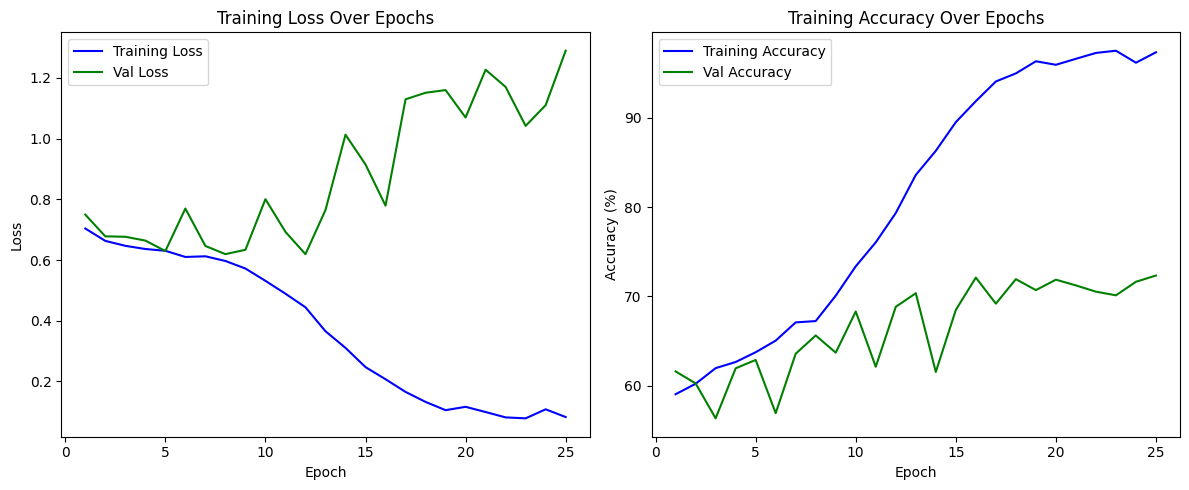

In [ ]:
def plot_training_history(history):
    """Plot training loss and accuracy over epochs."""
    epochs = range(1, len(history['train loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val loss'], 'g-', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train accuracy'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val accuracy'], 'g-', label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function after training
plot_training_history(history)

### Test on TestLoader

In [ ]:
# Load the best model
best_model = model  # Create a new model instance if necessary
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.to(device)

# Evaluate the best model on the test data
best_model.eval()  # Set the model to evaluation mode

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_epoch_loss = test_loss / len(val_loader.dataset)
test_epoch_accuracy = 100 * correct / total
print(f'Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_accuracy:.2f}%')

<ipython-input-19-d1368a33d275>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_model.pth'))


Test Loss: 0.6192, Test Accuracy: 68.84%


Predicted: 1, Actual: 0


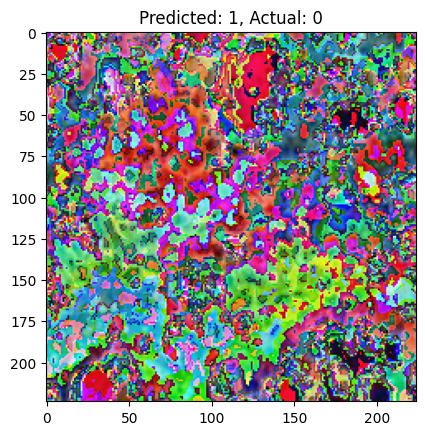

In [ ]:
# Get a single image and label from the test dataset
test_iter = iter(val_loader)
inputs, labels = next(test_iter)
inputs, labels = inputs.to(device), labels.to(device)

# Evaluate the model on this single image
with torch.no_grad():
    output = best_model(inputs[0].unsqueeze(0))  # Unsqueeze to add batch dimension
    _, predicted = torch.max(output, 1)

# Print the prediction and the actual label
print(f'Predicted: {predicted.item()}, Actual: {labels[0].item()}')

# Optionally, display the image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Convert tensor to PIL image for visualization (assuming inputs are normalized)
inv_normalize = transforms.Normalize(
    mean=[-0.485, -0.456, -0.406],
    std=[1/0.229, 1/0.224, 1/0.225]
)

img = inv_normalize(inputs[0].cpu())
img = transforms.ToPILImage()(img)

plt.imshow(img)
plt.title(f'Predicted: {predicted.item()}, Actual: {labels[0].item()}')
plt.show()